In [1]:
!pip install ultralytics opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00


In [2]:
import time
import cv2
import matplotlib.pyplot as plt
from ultralytics import SAM

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
start_load = time.time()
model = SAM('sam_b.pt')   # You can also try 'sam_l.pt' (larger but slower)
end_load = time.time()
print(f"✅ Model loaded in {end_load - start_load:.2f} seconds.")

✅ Model loaded in 12.22 seconds.


In [10]:
image_path = '/content/example1.webp'
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError("❌ Image not found. Please check your path!")


In [11]:
h, w = img.shape[:2]
scale = 512 / max(h, w)   # decrease image size to 512px max dimension
if scale < 1:
    img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
cv2.imwrite("resized_input.jpg", img)
image_path = "resized_input.jpg"

In [12]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

model = SAM('sam_b.pt')
model.to(device)

# (Optional) FP16 on GPU
use_half = (device == 'cuda')

Device: cuda


In [13]:
start_infer = time.time()
with torch.inference_mode():
    results = model.predict(
        source=image_path,
        retina_masks=False,
        imgsz=640,
        device=0 if device == 'cuda' else 'cpu',
        half=use_half  # FP16 on GPU
    )
end_infer = time.time()
print(f"🧠 Inference completed in {end_infer - start_infer:.2f} seconds.")


image 1/1 /content/resized_input.jpg: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1529.7ms
Speed: 2.6ms preprocess, 1529.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
🧠 Inference completed in 1.56 seconds.


Detected 13 objects in image.


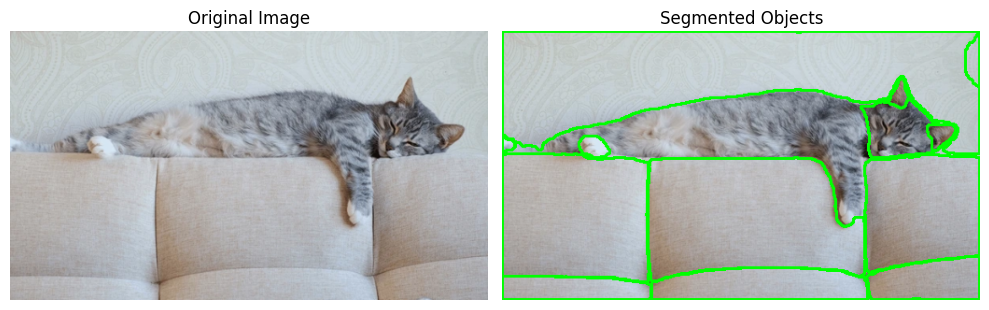

💾 Saved segmented image as segmented_output.jpg


In [14]:
for i, result in enumerate(results):
    # 'result.masks' is a Masks object with binary masks
    if result.masks is None:
        print("⚠️ No masks detected in this image.")
        continue

    masks = result.masks.data.cpu().numpy()  # shape: [num_objects, height, width]
    print(f"Detected {masks.shape[0]} objects in image.")

    # Visualize each mask overlayed on original image
    overlay = img.copy()
    for j, mask in enumerate(masks):
        colored_mask = (mask * 255).astype('uint8')
        contours, _ = cv2.findContours(colored_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)  # green outlines

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Segmented Objects")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    cv2.imwrite("segmented_output.jpg", overlay)
    print("💾 Saved segmented image as segmented_output.jpg")